In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


pd.options.display.max_rows = 8  
%matplotlib inline

读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt.head()
national_debt.describe()

national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.78%
2016/1/22,2.705,2.689,2.705,2.682,-0.41%
2016/1/25,2.750,2.694,2.750,2.680,0.19%
2016/1/26,2.703,2.738,2.740,2.690,1.63%
2016/1/27,2.763,2.774,2.783,2.763,1.31%


,开盘,收盘,高,低
count,1563.000000,1563.000000,1563.000000,1563.000000
mean,3.041862,3.022280,3.049060,3.010074
std,0.419688,0.420101,0.418939,0.420670
min,1.740000,1.740000,1.740000,1.740000
25%,2.746000,2.712000,2.750000,2.697000
50%,3.012000,2.993000,3.018000,2.983000
75%,3.261000,3.234000,3.269000,3.219000
max,4.000000,3.968000,4.000000,3.952000


,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


开盘价原始数据可视化

<Figure size 432x288 with 0 Axes>

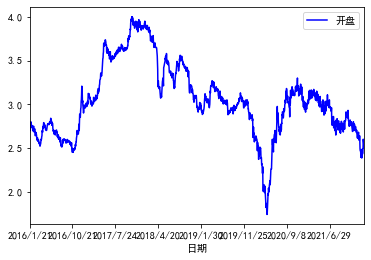

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
    
draw_ts(pd.DataFrame(national_debt['开盘']))

数据预处理

In [4]:
# 前(1563-600=963)天的开盘价作为训练集,表格从0开始计数，,0:1 是提取[0:1)列，前闭后开
training_set = national_debt.iloc[0:1563 - 600,0:].values  

#中间300天的数据作为验证集
valid_set= national_debt.iloc[1563 - 600:1563 - 300, 0:].values  

# 后300天的开盘价作为测试集
test_set = national_debt.iloc[1563 - 300:1563, 0:].values  

# 归一化
sc = MinMaxScaler(feature_range=(0, 1))  # 定义归一化：归一化到(0，1)之间
training_set_scaled = sc.fit_transform(training_set)  # 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
valid_set = sc.transform(valid_set)
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

#对开盘价数据进行归一化，方便后续可视化展示
sc_for_visual = MinMaxScaler(feature_range=(0, 1))  
y_test_for_visual_scaled = sc_for_visual.fit_transform(national_debt.iloc[0:1563 - 600, 0:1].values ) 
y_test_for_visual = sc_for_visual.transform(national_debt.iloc[1563 - 300:1563, 0:1].values )

得到训练集和测试集的数据

In [5]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []

# 利用for循环，遍历整个训练集，提取训练集中连续10天的开盘价作为输入特征x_train，第11天的数据作为标签
for i in range(10, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - 10:i, 1:]) 
    y_train.append(training_set_scaled[i, 0])


# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 10,4))
print(x_train)

#验证集
for i in range(10, len(valid_set)):
    x_valid.append(valid_set[i - 10:i,1:])
    y_valid.append(valid_set[i, 0])
x_valid, y_valid = np.array(x_valid), np.array(y_valid)
x_valid = np.reshape(x_valid, (x_valid.shape[0], 10,4))


# 测试集：csv表格中后300天数据
# 利用for循环，遍历整个测试集，提取测试集中连续10天的开盘价作为输入特征x_train，
# 第11天的数据作为标签，for循环共构建300-10=290组数据。
for i in range(10, len(test_set)):
    x_test.append(test_set[i - 10:i,1:])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合CNN和RNN输入要求：
#RNN: [送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0],10,4))

[[[0.18613607 0.16322581 0.18825782 0.49134615]
  [0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  ...
  [0.22400513 0.21935484 0.20102106 0.3125    ]
  [0.20667522 0.20967742 0.21825144 0.32211538]
  [0.21630295 0.19677419 0.22846203 0.46923077]]

 [[0.17907574 0.16451613 0.18953414 0.37692308]
  [0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  ...
  [0.20667522 0.20967742 0.21825144 0.32211538]
  [0.21630295 0.19677419 0.22846203 0.46923077]
  [0.2156611  0.19870968 0.22782387 0.4125    ]]

 [[0.18228498 0.19354839 0.18825782 0.43461538]
  [0.21052632 0.18709677 0.19463944 0.57307692]
  [0.23363286 0.21483871 0.24122527 0.54230769]
  ...
  [0.21630295 0.19677419 0.22846203 0.46923077]
  [0.2156611  0.19870968 0.22782387 0.4125    ]
  [0.20603338 0.19870968 0.22016592 0.36346154]]

 ...

 [[0.31643132 0.29354839 0.3114231  0.51634615]
  [0.32926829 0.3083871  0.33056796 0.48269231]
  [0.32413

训练模型

Train...
Epoch 1/300
15/15 [==============================] - 2s 155ms/step - loss: 0.3090 - val_loss: 0.0959
Epoch 2/300
15/15 [==============================] - 1s 40ms/step - loss: 0.3005 - val_loss: 0.0949
Epoch 3/300
15/15 [==============================] - 1s 36ms/step - loss: 0.2904 - val_loss: 0.0939
Epoch 4/300
15/15 [==============================] - 0s 33ms/step - loss: 0.2754 - val_loss: 0.0932
Epoch 5/300
15/15 [==============================] - 1s 42ms/step - loss: 0.2661 - val_loss: 0.0925
Epoch 6/300
15/15 [==============================] - 1s 46ms/step - loss: 0.2573 - val_loss: 0.0919
Epoch 7/300
15/15 [==============================] - 1s 33ms/step - loss: 0.2415 - val_loss: 0.0915
Epoch 8/300
15/15 [==============================] - 0s 32ms/step - loss: 0.2296 - val_loss: 0.0910
Epoch 9/300
15/15 [==============================] - 0s 31ms/step - loss: 0.2177 - val_loss: 0.0907
Epoch 10/300
15/15 [==============================] - 0s 29ms/step - loss: 0.2051 - val_lo

15/15 [==============================] - 1s 36ms/step - loss: 0.0130 - val_loss: 0.0286
Epoch 83/300
15/15 [==============================] - 1s 41ms/step - loss: 0.0142 - val_loss: 0.0284
Epoch 84/300
15/15 [==============================] - 1s 36ms/step - loss: 0.0125 - val_loss: 0.0279
Epoch 85/300
15/15 [==============================] - 1s 35ms/step - loss: 0.0137 - val_loss: 0.0278
Epoch 86/300
15/15 [==============================] - 1s 35ms/step - loss: 0.0122 - val_loss: 0.0277
Epoch 87/300
15/15 [==============================] - 1s 35ms/step - loss: 0.0125 - val_loss: 0.0275
Epoch 88/300
15/15 [==============================] - 0s 18ms/step - loss: 0.0140 - val_loss: 0.0275
Epoch 89/300
15/15 [==============================] - 1s 34ms/step - loss: 0.0117 - val_loss: 0.0274
Epoch 90/300
15/15 [==============================] - 0s 32ms/step - loss: 0.0112 - val_loss: 0.0273
Epoch 91/300
15/15 [==============================] - 1s 34ms/step - loss: 0.0123 - val_loss: 0.0272
Epo

15/15 [==============================] - 1s 46ms/step - loss: 0.0067 - val_loss: 0.0206
Epoch 243/300
15/15 [==============================] - 0s 32ms/step - loss: 0.0066 - val_loss: 0.0206
Epoch 244/300
15/15 [==============================] - 0s 31ms/step - loss: 0.0063 - val_loss: 0.0207
Epoch 245/300
15/15 [==============================] - 0s 18ms/step - loss: 0.0069 - val_loss: 0.0208
Epoch 246/300
15/15 [==============================] - 0s 30ms/step - loss: 0.0070 - val_loss: 0.0208
Epoch 247/300
15/15 [==============================] - 0s 18ms/step - loss: 0.0078 - val_loss: 0.0207
Epoch 248/300
15/15 [==============================] - 0s 31ms/step - loss: 0.0070 - val_loss: 0.0206
Epoch 249/300
15/15 [==============================] - 0s 31ms/step - loss: 0.0065 - val_loss: 0.0208
Epoch 250/300
15/15 [==============================] - 0s 32ms/step - loss: 0.0066 - val_loss: 0.0208
Epoch 251/300
15/15 [==============================] - 0s 31ms/step - loss: 0.0059 - val_loss: 0

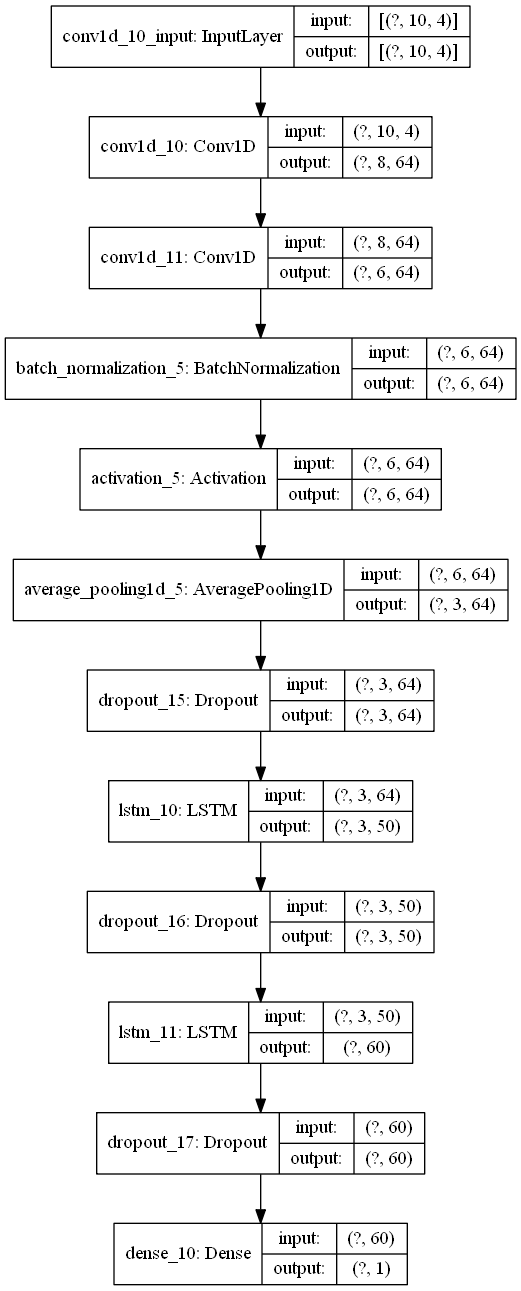

19

11

12882

17

6

762

19

12

1518

17

6

977

30

6

707

29

6

1041

30

10

490

40

10

491

28

7

3251

30

10

491

40

10

492

28

7

3901

18

8

901

16

5

13

In [23]:
import os
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,BatchNormalization
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D,Flatten,AveragePooling1D
from tensorflow.keras import Model
from tensorflow import keras


# Convolution
kernel_size = 3
filters = 64
pool_size = 2


# Training
batch_size = 64
epochs = 300

model = Sequential()

model.add(Conv1D(filters, kernel_size,padding='valid', activation='relu',  strides=1))                                      
model.add(Conv1D(filters, kernel_size,padding='valid', activation='relu', strides=1))

model.add(BatchNormalization()) # BN层
model.add(Activation('relu'))    # 激活层  

model.add(AveragePooling1D(pool_size=pool_size))
model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(keras.layers.Reshape((832, 1)))

model.add(LSTM(50,return_sequences=True)) 
model.add(Dropout(0.2))
model.add(LSTM(60))  #第二层
model.add(Dropout(0.2))
model.add(Dense(1))
# model.add(Activation('sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss='mean_squared_error')  # 损失函数用均方误差

#该应用只观测loss数值，不观测准确率，所以删去metrics选项，一会在每个epoch迭代显示时只显示loss值
checkpoint_save_path = "./checkpoint/CMM-LSTM/CNN-LSTM_nation_debt.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

print('Train...')
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,
                    validation_data=(x_valid, y_valid),validation_freq=1,callbacks=[cp_callback])
model.summary()

keras.utils.plot_model(model, "data/shape_info_by_cnn-lstm.png", show_shapes=True)


file = open('./data/weights_of_nation_debt_by_cnn-lstm.txt', 'w')  # 参数提取
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

Text(0.5, 1.0, 'Training and Validation Loss')

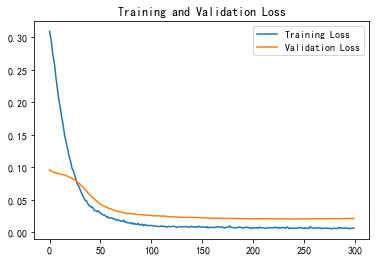

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss') #验证集用来选则最佳的超参数的值
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'national debt Price')

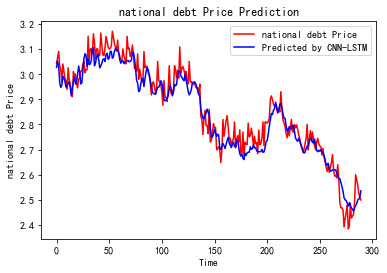

均方误差: 0.002275
均方根误差: 0.047698
平均绝对误差: 0.036638


In [27]:
# 测试集输入模型进行预测
predicted_stock_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_price = sc_for_visual.inverse_transform(predicted_stock_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_price = sc_for_visual.inverse_transform(y_test_for_visual[10:])
# 画出真实数据和预测数据的对比曲线
# 画出真实数据和预测数据的对比曲线
plt.figure(facecolor='white')
plt.plot(real_stock_price, color='red', label='national debt Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted by CNN-LSTM')
plt.title('national debt Price Prediction')
plt.xlabel('Time')
plt.ylabel('national debt Price')
plt.legend()
plt.show()

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_price, real_stock_price)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_stock_price, real_stock_price))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_price, real_stock_price)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

In [26]:
from sklearn.metrics import explained_variance_score
import seaborn as sns

cm = explained_variance_score(real_stock_price, predicted_stock_price)

print(cm )

0.9409247627682897
